## Simulation regarding the baevsky stress index on Neurokit2 simulation

Stuff

In [103]:
## Plot the data simulation PPG with different noise levels and heart rates (60, 80, 100 bpm)
import neurokit2 as nk
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.signal import resample
from scipy.interpolate import CubicSpline

In [78]:

# ## Open the .npy files from the subject s51
# pos_path = os.path.join("s56", f"s56_T3_POS_rppg.npy")
# pos_signal = np.load(pos_path)

# ## Clean the pos signal with simple PPG processing
# pos_signal = nk.ppg_clean(pos_signal, sampling_rate=35)

# Simulate or use real PPG
ppg = nk.ppg_simulate(duration=60, sampling_rate=1000, heart_rate=80)
cleaned = nk.ppg_clean(ppg, sampling_rate=1000)
signals, info = nk.ppg_peaks(cleaned, sampling_rate=1000)

# Get peak indices
peak_indices = info["PPG_Peaks"]

# nk.ppg_plot(signals, info)

# Convert to RR intervals in milliseconds
rr_intervals = np.diff(peak_indices) / 1000.0 * 1000  # in ms

# Calculate histogram
bins = np.arange(int(rr_intervals.min()), int(rr_intervals.max()) + 10, 10)
hist, bin_edges = np.histogram(rr_intervals, bins=bins)

# Mo: most frequent RR interval (mode bin center)
mode_bin = bin_edges[np.argmax(hist)]
Mo = mode_bin

# AMo: percentage of RR intervals in the mode bin
AMo = (np.max(hist) / len(rr_intervals)) * 100

# MxDMn: range of RR intervals
MxDMn = np.max(rr_intervals) - np.min(rr_intervals)

# Baevsky Stress Index
SI = (AMo * 100) / (2 * Mo * MxDMn)

print(f"Baevsky Stress Index (SI): {SI:.2f}")



Baevsky Stress Index (SI): 0.00


## Stuff

Paradox rest task have higher BPM, compare to the stressor

In [79]:
import numpy as np
import pandas as pd
import neurokit2 as nk
import matplotlib.pyplot as plt
from scipy import signal

def process_rppg_signal(rppg_signal, sampling_rate=30):
    """
    Process rPPG signal to find peaks and calculate RR intervals
    
    Parameters:
    rppg_signal (array): Raw rPPG signal
    sampling_rate (int): Sampling rate in Hz (default: 30 Hz for typical webcam-based rPPG)
    
    Returns:
    tuple: (cleaned_signal, peaks, rr_intervals)
    """
    # Clean the signal (remove noise, detrend, normalize)
    cleaned_signal = nk.ppg_clean(rppg_signal, sampling_rate=sampling_rate)
    
    # Find peaks in the cleaned signal
    peaks, info = nk.ppg_peaks(cleaned_signal, sampling_rate=sampling_rate)
    
    # Get peak indices
    peak_indices = np.where(peaks["PPG_Peaks"] == 1)[0]
    
    # Calculate RR intervals (convert to milliseconds)
    rr_intervals = np.diff(peak_indices) * (1000 / sampling_rate)
    
    return cleaned_signal, peak_indices, rr_intervals

def calculate_baevsky_stress_index_revised(rr_intervals):
    """
    Calculate the Baevsky Stress Index from RR intervals with scaling
    
    Parameters:
    rr_intervals (array): Array of RR intervals in milliseconds
    
    Returns:
    float: Stress index value
    """
    # Filter extreme values (physiologically implausible)
    filtered_rr = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 1500)]
    
    if len(filtered_rr) < 30:
        raise ValueError("Not enough valid RR intervals for analysis (minimum 30 required)")
    
    # Calculate mode (Mo) - the most common RR interval value
    hist, bin_edges = np.histogram(filtered_rr, bins=50)
    bin_idx = np.argmax(hist)
    Mo = (bin_edges[bin_idx] + bin_edges[bin_idx + 1]) / 2
    
    # Calculate AMo (amplitude of mode) - percentage of intervals corresponding to mode value
    # Using the stricter definition: percentage in the modal bin only
    AMo = 100 * hist[bin_idx] / len(filtered_rr)
    
    # Calculate MxDMn (variation range) - difference between max and min RR intervals
    MxDMn = np.max(filtered_rr) - np.min(filtered_rr)
    
    # Calculate Stress Index using revised Baevsky's formula with scaling factor
    stress_index = (AMo / 100) / (2 * Mo / 1000 * MxDMn / 1000) * 1000
    # This simplifies to: stress_index = AMo * 1000 / (2 * Mo * MxDMn / 1000)
    
    return stress_index

def visualize_analysis(rppg_signal, cleaned_signal, peak_indices, rr_intervals, stress_index, sampling_rate=30):
    """
    Visualize rPPG signal, detected peaks, RR intervals, and stress index
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Original and cleaned signal with peaks
    t = np.arange(len(rppg_signal)) / sampling_rate
    axes[0].plot(t, rppg_signal, 'b-', alpha=0.5, label='Raw rPPG')
    axes[0].plot(t, cleaned_signal, 'g-', label='Cleaned rPPG')
    axes[0].plot(peak_indices / sampling_rate, cleaned_signal[peak_indices], 'ro', label='Detected Peaks')
    axes[0].set_title('rPPG Signal and Peak Detection')
    axes[0].set_xlabel('Time (s)')
    axes[0].set_ylabel('Amplitude')
    axes[0].legend()
    
    # RR intervals
    axes[1].plot(rr_intervals, 'b-')
    axes[1].set_title('RR Intervals')
    axes[1].set_xlabel('Beat number')
    axes[1].set_ylabel('RR Interval (ms)')
    
    # Histogram of RR intervals
    axes[2].hist(rr_intervals, bins=30, alpha=0.7)
    axes[2].set_title(f'RR Interval Distribution (Baevsky Stress Index: {stress_index:.2f})')
    axes[2].set_xlabel('RR Interval (ms)')
    axes[2].set_ylabel('Frequency')
    
    plt.tight_layout()
    plt.show()



In [95]:
def upsample_rppg(signal, original_fs=35, target_fs=100):
    """Upsample rPPG signal using cubic spline interpolation"""
    # # Original time points
    # original_time = np.arange(len(signal)) / original_fs
    
    # # New time points at higher sampling rate
    # new_time = np.arange(0, original_time[-1], 1/target_fs)
    
    # # Cubic spline interpolation
    # from scipy.interpolate import CubicSpline
    # cs = CubicSpline(original_time, signal)
    # upsampled_signal = cs(new_time)
    
    # return upsampled_signal, target_fs

    # Upsample to ~140 Hz
    rppg_upsampled = resample(signal, int(len(signal) * target_fs / original_fs))
    return rppg_upsampled, target_fs


## Notes
Well I forget that samples / time length also defines the SI to be more precise, 1 minute will probably give much higher than the standard 3 - 5 mins sample, but it was fine

Baevsky Stress Index (SI): 236.71


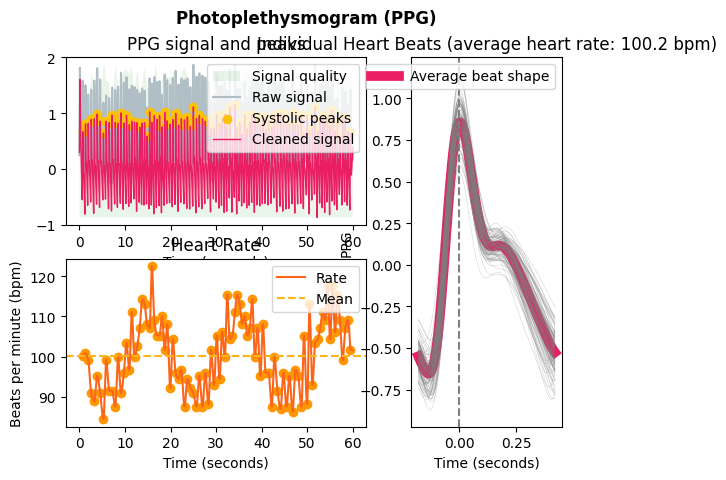

In [ ]:
## Simulate a synthetic rPPG signal
sampling_rate = 35  # Hz
ppg = nk.ppg_simulate(duration=180, sampling_rate=35, heart_rate=180)

## Open the .npy files from the subject s51
pos_path = os.path.join("s53", f"s53_T1_POS_rppg.npy")
pos_signal = np.load(pos_path)

## Upsample the pos signal to 100 Hz
upsampled_signal, target_fs = upsample_rppg(ppg, original_fs=35, target_fs=200)

## Process the PPG signal
signals, info = nk.ppg_process(upsampled_signal, sampling_rate=target_fs)

## PPG plot
nk.ppg_plot(signals, info)

# Process the signal
cleaned_signal, peak_indices, rr_intervals = process_rppg_signal(upsampled_signal, target_fs)

# Calculate Baevsky Stress Index
stress_index = calculate_baevsky_stress_index_revised(rr_intervals)

# Print results
print(f"Baevsky Stress Index (SI): {stress_index:.2f}")

# Visualize results
# visualize_analysis(ppg, cleaned_signal, peak_indices, rr_intervals, stress_index, sampling_rate)


## Differences Between Interpolation and Resampling

In signal processing, especially for physiological data analysis like PPG/rPPG signals, understanding the difference between interpolation (like `scipy.interpolate.interp1d`) and resampling (like `scipy.signal.resample`) is crucial:

### Interpolation (`scipy.interpolate.interp1d`):
- **What it does**: Creates a function that can estimate values at arbitrary points between known data points
- **How it works**: Uses mathematical functions (linear, cubic splines, etc.) to "connect the dots" between existing points
- **Use cases**:
  - Creating equally spaced time series from irregularly sampled data (e.g., RR intervals)
  - Estimating values at specific timestamps not present in original data
  - Preparing data for frequency analysis when samples aren't uniformly spaced
- **Preserves**: Original data points exactly (the function passes through all original points)
- **Example in HRV analysis**: Converting unevenly spaced heartbeat intervals to a continuous, evenly sampled time series

### Resampling (`scipy.signal.resample`):
- **What it does**: Changes the sampling rate of a signal, creating a new uniformly spaced signal
- **How it works**: Applies Fourier methods to maintain frequency content while changing the number of samples
- **Use cases**:
  - Changing sampling frequency (e.g., from 64Hz to 30Hz)
  - Making signals with different sampling rates compatible
  - Downsampling to reduce computational load or storage requirements
- **Preserves**: Frequency content, but not necessarily original values at specific points
- **Example in PPG processing**: Converting a 64Hz ground truth PPG signal to match the 30Hz camera-derived rPPG signal

### Key Differences:
1. **Purpose**: 
   - Interpolation: Estimating values between known points
   - Resampling: Changing the sampling rate while preserving frequency characteristics

2. **Mathematical approach**:
   - Interpolation: Local fitting between adjacent points
   - Resampling: Global transformation using Fourier methods

3. **Effect on signal**:
   - Interpolation: May not preserve frequency characteristics perfectly
   - Resampling: Designed to preserve frequency content but can introduce artifacts

4. **In the rPPG workflow**:
   - Use resampling when changing from one uniform sampling rate to another (e.g., `scipy.signal.resample`)
   - Use interpolation when working with irregularly spaced data like RR intervals (e.g., `interp1d`)

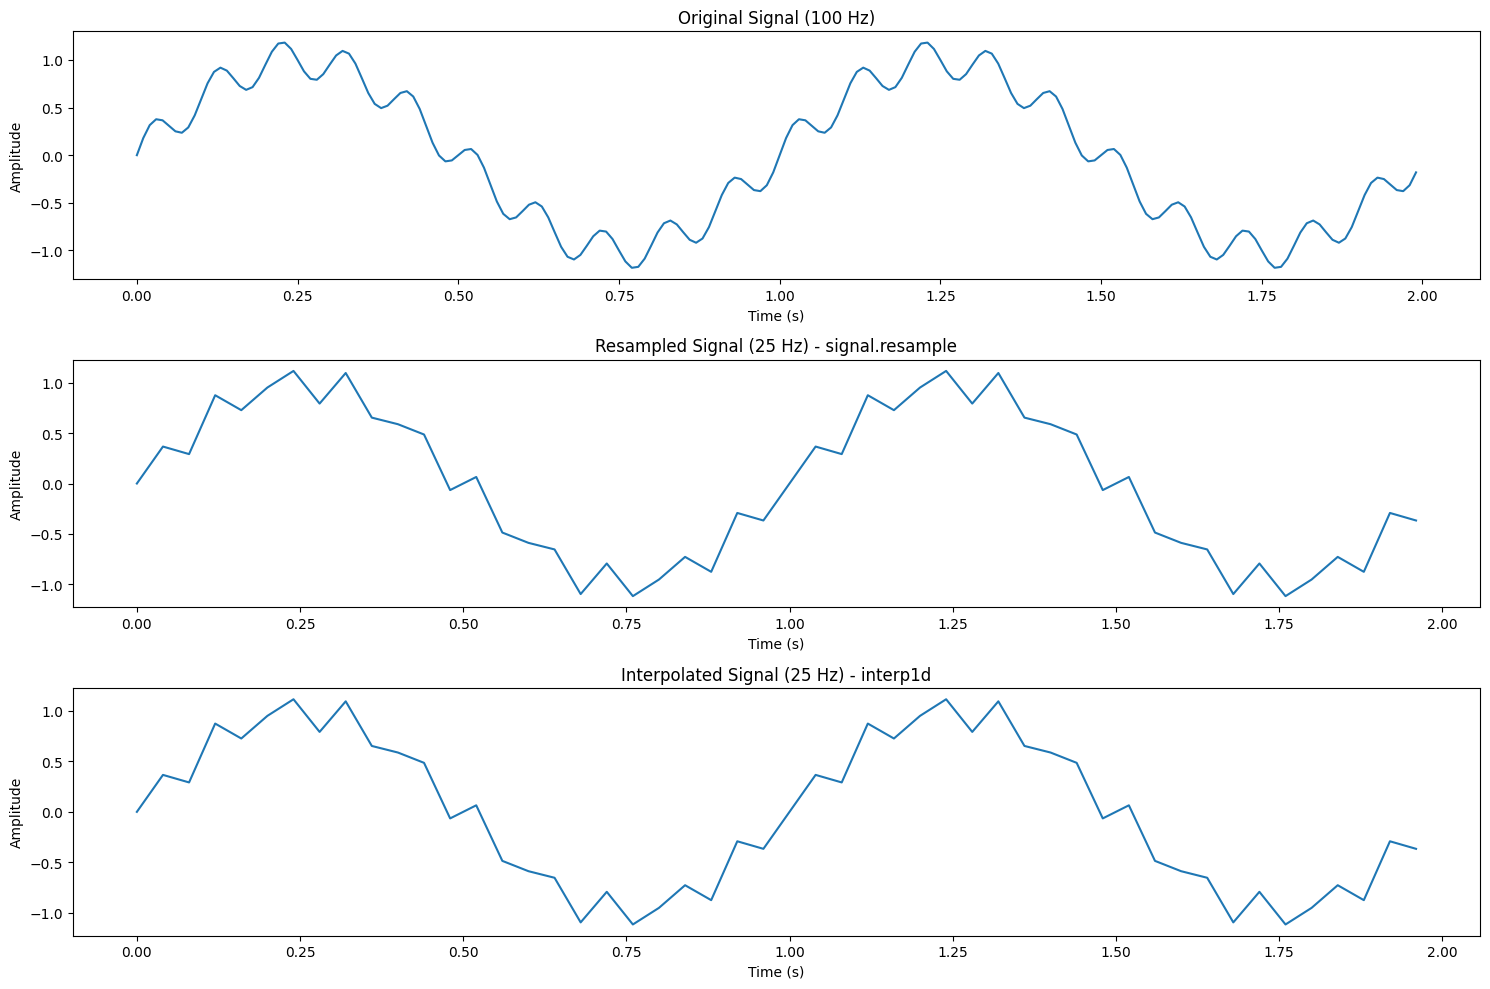

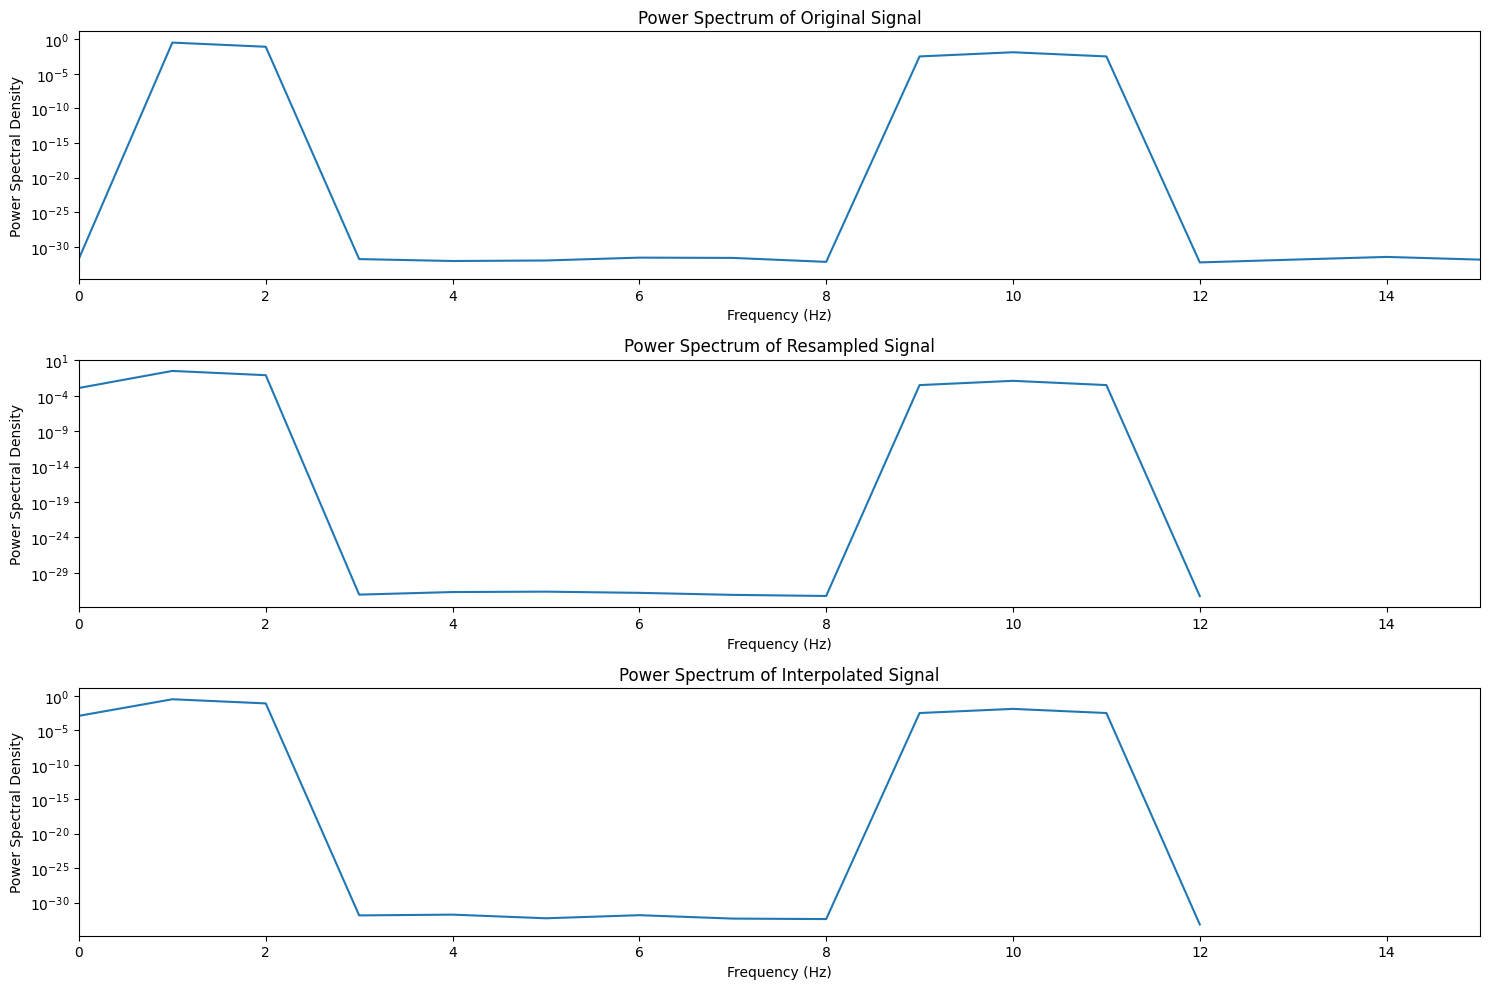

Key observations:
1. Resampling (signal.resample) preserves the frequency content better, 
   especially important for spectral analysis of physiological signals
2. Interpolation (interp1d) follows the original signal shape but can alter frequency components
3. When downsampling, resampling properly handles the Nyquist limit while interpolation may not
4. For HRV analysis with irregular heart beats, interpolation is necessary to create evenly spaced time series


In [82]:
# Demonstration of resampling vs interpolation differences
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.interpolate import interp1d

# Create a sample signal (simulating PPG)
fs_original = 100  # Original sampling rate (Hz)
t_original = np.arange(0, 2, 1/fs_original)  # 2 seconds of data at 100 Hz
# Create a signal with known frequency components (1 Hz and 10 Hz)
signal_original = np.sin(2*np.pi*1*t_original) + 0.2*np.sin(2*np.pi*10*t_original)

# Target lower sampling rate
fs_target = 25  # Hz

# Method 1: scipy.signal.resample (Fourier method)
t_resampled = np.arange(0, 2, 1/fs_target)  # New time points
signal_resampled = signal.resample(signal_original, len(t_resampled))

# Method 2: scipy.interpolate.interp1d
interpolator = interp1d(t_original, signal_original, kind='cubic')
t_interpolated = np.arange(0, 2, 1/fs_target)  # Same time points for comparison
signal_interpolated = interpolator(t_interpolated)

# Plot the results
plt.figure(figsize=(15, 10))

# Original signal
plt.subplot(3, 1, 1)
plt.plot(t_original, signal_original)
plt.title(f'Original Signal ({fs_original} Hz)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Resampled signal
plt.subplot(3, 1, 2)
plt.plot(t_resampled, signal_resampled)
plt.title(f'Resampled Signal ({fs_target} Hz) - signal.resample')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Interpolated signal
plt.subplot(3, 1, 3)
plt.plot(t_interpolated, signal_interpolated)
plt.title(f'Interpolated Signal ({fs_target} Hz) - interp1d')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

# Compare in frequency domain to see the differences
plt.figure(figsize=(15, 10))

# Original signal spectrum
plt.subplot(3, 1, 1)
f_original, Pxx_original = signal.welch(signal_original, fs=fs_original, nperseg=len(t_original)//2)
plt.semilogy(f_original, Pxx_original)
plt.title('Power Spectrum of Original Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.xlim(0, 15)  # Limit x-axis to focus on our frequencies of interest

# Resampled signal spectrum
plt.subplot(3, 1, 2)
f_resampled, Pxx_resampled = signal.welch(signal_resampled, fs=fs_target, nperseg=len(t_resampled)//2)
plt.semilogy(f_resampled, Pxx_resampled)
plt.title('Power Spectrum of Resampled Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.xlim(0, 15)

# Interpolated signal spectrum
plt.subplot(3, 1, 3)
f_interp, Pxx_interp = signal.welch(signal_interpolated, fs=fs_target, nperseg=len(t_interpolated)//2)
plt.semilogy(f_interp, Pxx_interp)
plt.title('Power Spectrum of Interpolated Signal')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power Spectral Density')
plt.xlim(0, 15)

plt.tight_layout()
plt.show()

# Print some observations
print("Key observations:")
print("1. Resampling (signal.resample) preserves the frequency content better, ")
print("   especially important for spectral analysis of physiological signals")
print("2. Interpolation (interp1d) follows the original signal shape but can alter frequency components")
print("3. When downsampling, resampling properly handles the Nyquist limit while interpolation may not")
print("4. For HRV analysis with irregular heart beats, interpolation is necessary to create evenly spaced time series")

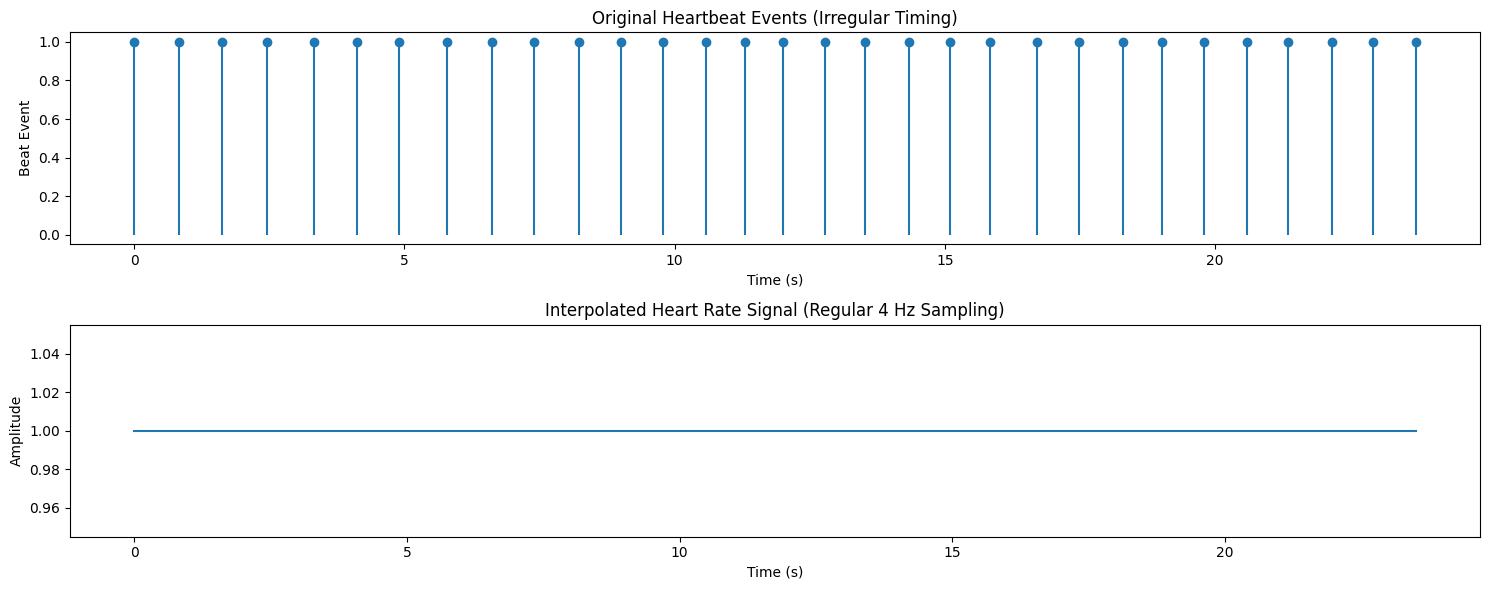


In HRV analysis:
1. We start with irregularly spaced heartbeats (RR intervals)
2. We need evenly sampled data for frequency domain analyses (LF/HF ratio, etc.)
3. Interpolation (not resampling) is required to convert from event-based to time-series
4. This is why 'interp1d' is used in the HRV calculation sections of your code
5. Regular resampling isn't applicable here because the original data isn't uniformly sampled


In [83]:
# Real-world example: HRV analysis with RR intervals

# Simulate irregular heartbeats (RR intervals)
np.random.seed(42)
# Create 30 heart beats with natural variability (around 75 BPM = ~800ms intervals)
rr_intervals = np.random.normal(800, 50, 30)  # in milliseconds

# Create cumulative time points where each heartbeat occurs (in seconds)
beat_times = np.cumsum(rr_intervals) / 1000.0
beat_times = np.insert(beat_times, 0, 0)  # add first beat at time 0

# Create a pulse signal at each beat location (1 at beat, 0 elsewhere)
pulse_signal = np.zeros(len(beat_times))
pulse_signal[0] = 1  # first beat
pulse_signal[1:] = 1  # remaining beats

# This is where we need interpolation: to convert irregular beat intervals to evenly sampled time series
# Target sampling rate for consistent analysis
target_fs = 4  # Hz, standard for HRV analysis
target_times = np.arange(0, beat_times[-1], 1/target_fs)

# Interpolate the series of heartbeats to get a continuous signal
interp_cubic = interp1d(beat_times, pulse_signal, kind='cubic', bounds_error=False, fill_value=0)
ibi_signal = interp_cubic(target_times)

# Plot the results
plt.figure(figsize=(15, 6))

plt.subplot(2, 1, 1)
plt.stem(beat_times, pulse_signal, basefmt=" ")
plt.title('Original Heartbeat Events (Irregular Timing)')
plt.xlabel('Time (s)')
plt.ylabel('Beat Event')

plt.subplot(2, 1, 2)
plt.plot(target_times, ibi_signal)
plt.title(f'Interpolated Heart Rate Signal (Regular {target_fs} Hz Sampling)')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

print("\nIn HRV analysis:")
print("1. We start with irregularly spaced heartbeats (RR intervals)")
print("2. We need evenly sampled data for frequency domain analyses (LF/HF ratio, etc.)")
print("3. Interpolation (not resampling) is required to convert from event-based to time-series")
print("4. This is why 'interp1d' is used in the HRV calculation sections of your code")
print("5. Regular resampling isn't applicable here because the original data isn't uniformly sampled")


### Java

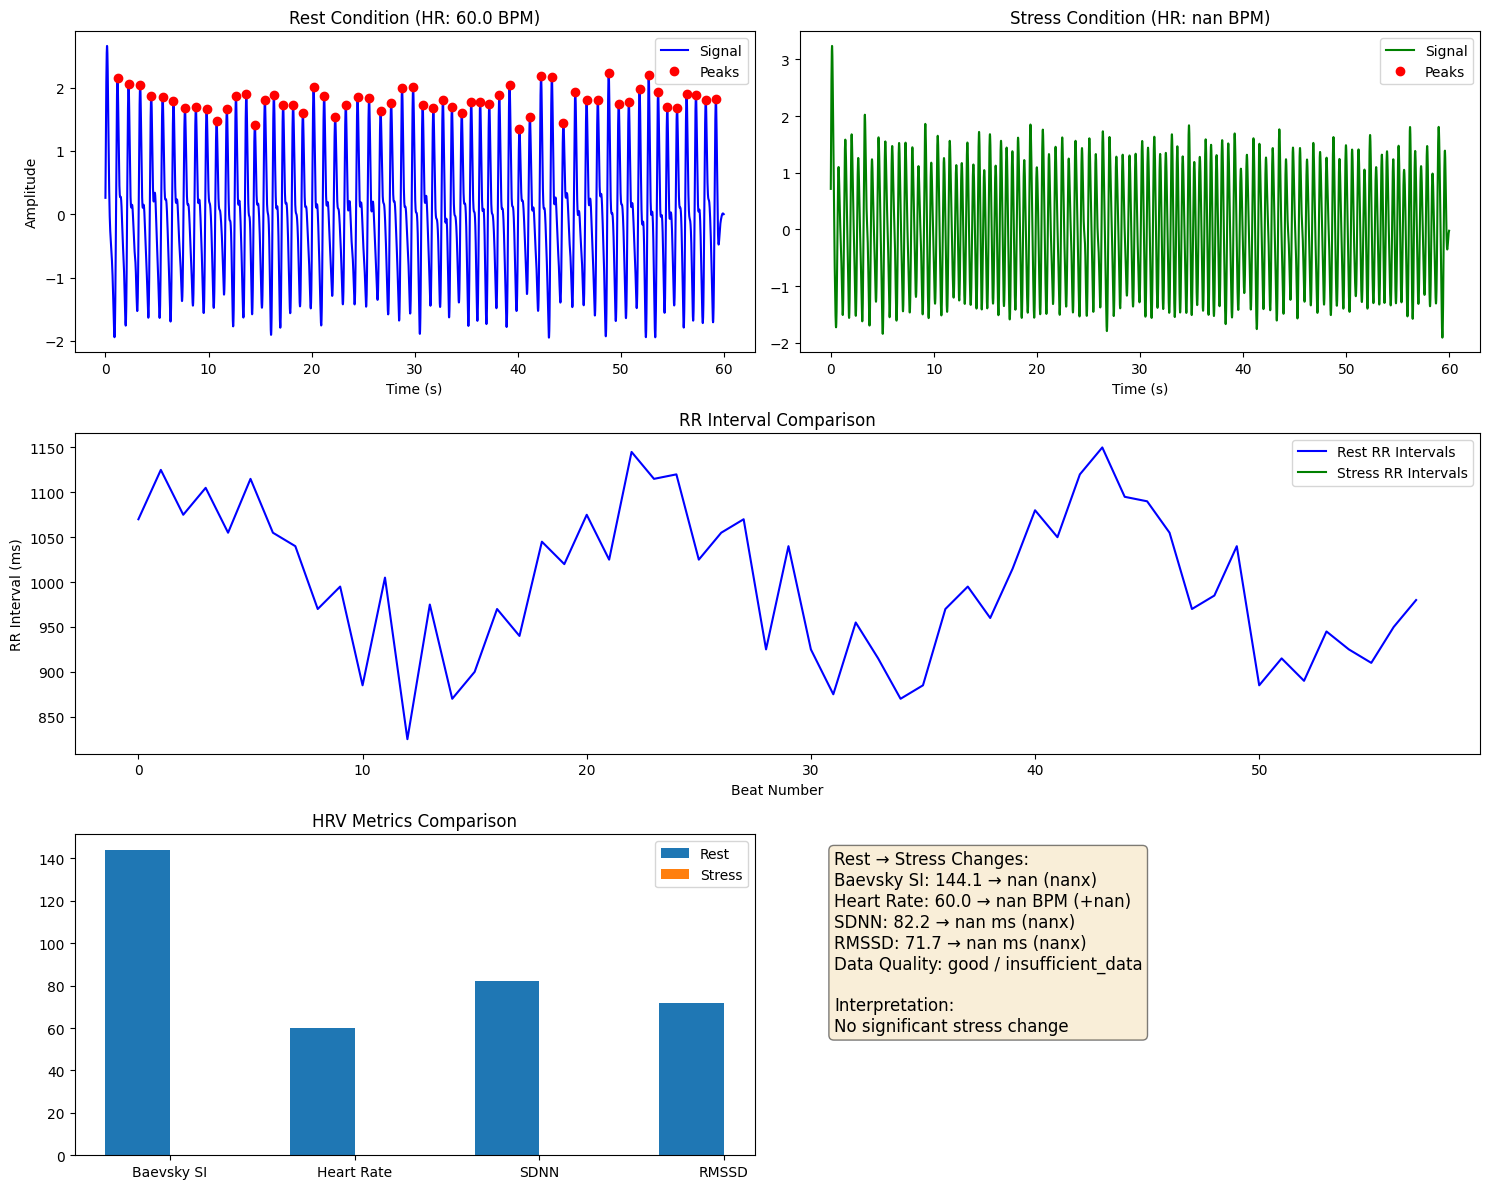

Analysis complete. Key metrics:
Rest SI: 144.12
Stress SI: nan
SI Ratio (Stress/Rest): nan


In [109]:
def comprehensive_stress_analysis(rest_signal, stress_signal, original_fs=35, 
                                 segment_duration=60, visualize=True):
    """
    Comprehensive analysis of rPPG signals during rest and stressor tasks
    
    Parameters:
    -----------
    rest_signal : array
        rPPG signal during rest condition
    stress_signal : array
        rPPG signal during stressor task
    original_fs : int
        Original sampling frequency of the signals (default: 35 Hz)
    segment_duration : int
        Duration in seconds for analysis segments (default: 60 seconds)
    visualize : bool
        Whether to generate visualization of the results (default: True)
        
    Returns:
    --------
    dict
        Dictionary containing all analysis results
    """
    # Step 1: Upsample both signals to improve temporal resolution
    rest_up, target_fs = upsample_rppg(rest_signal, original_fs, target_fs=200)
    stress_up, _ = upsample_rppg(stress_signal, original_fs, target_fs=200)
    
    # Step 2: Enhanced preprocessing optimized for rPPG
    rest_clean = enhanced_cleaning(rest_up, target_fs)
    stress_clean = enhanced_cleaning(stress_up, target_fs)
    
    # Step 3: Optimized peak detection with condition-specific parameters
    rest_peaks = condition_specific_peak_detection(rest_clean, target_fs, "rest")
    stress_peaks = condition_specific_peak_detection(stress_clean, target_fs, "stress")
    
    # Step 4: Calculate RR intervals and filter outliers
    rest_rr = extract_clean_rr_intervals(rest_peaks, target_fs)
    stress_rr = extract_clean_rr_intervals(stress_peaks, target_fs)
    
    # Step 5: Calculate Baevsky Stress Index and other HRV metrics
    rest_metrics = calculate_comprehensive_hrv(rest_rr)
    stress_metrics = calculate_comprehensive_hrv(stress_rr)
    
    # Step 6: Create results summary
    results = {
        "rest": {
            "metrics": rest_metrics,
            "rr_intervals": rest_rr,
            "signal": {
                "raw": rest_signal,
                "upsampled": rest_up,
                "cleaned": rest_clean
            },
            "peaks": rest_peaks
        },
        "stress": {
            "metrics": stress_metrics,
            "rr_intervals": stress_rr,
            "signal": {
                "raw": stress_signal,
                "upsampled": stress_up,
                "cleaned": stress_clean
            },
            "peaks": stress_peaks
        },
        "comparison": {
            "si_ratio": stress_metrics["baevsky_si"] / rest_metrics["baevsky_si"],
            "hr_change": stress_metrics["heart_rate"] - rest_metrics["heart_rate"],
            "sdnn_ratio": stress_metrics["sdnn"] / rest_metrics["sdnn"],
            "rmssd_ratio": stress_metrics["rmssd"] / rest_metrics["rmssd"]
        }
    }
    
    # Step 7: Visualize if requested
    if visualize:
        visualize_stress_analysis(results, target_fs)
    
    return results

def upsample_rppg(signal, original_fs=35, target_fs=200):
    """
    Upsample rPPG signal using cubic spline interpolation
    
    Parameters:
    -----------
    signal : array
        Original rPPG signal
    original_fs : int
        Original sampling frequency in Hz
    target_fs : int
        Target sampling frequency in Hz
        
    Returns:
    --------
    tuple
        (upsampled_signal, target_fs)
    """
    # Create time arrays
    original_time = np.arange(len(signal)) / original_fs
    new_time = np.arange(0, original_time[-1], 1/target_fs)
    
    # Perform cubic spline interpolation
    cs = CubicSpline(original_time, signal)
    upsampled_signal = cs(new_time)
    
    return upsampled_signal, target_fs

def enhanced_cleaning(signal, fs):
    """
    Enhanced cleaning procedure optimized for rPPG signals
    
    Parameters:
    -----------
    signal : array
        rPPG signal to clean
    fs : int
        Sampling frequency in Hz
        
    Returns:
    --------
    array
        Cleaned signal
    """
    # Step 1: Detrend to remove slow drifts
    detrended = nk.signal_detrend(signal, method="polynomial", order=3)
    
    # Step 2: Bandpass filter focused on heart rate range
    # Typical HR range for adults: 40-180 BPM = 0.67-3 Hz
    filtered = nk.signal_filter(detrended, lowcut=0.67, highcut=3.0, 
                              sampling_rate=fs, method="butterworth", order=4)
    
    # Step 3: Remove remaining artifacts using wavelet method
    # wavelet_cleaned = nk.signal_filter(filtered, method="wavelet", sampling_rate=fs)
    
    # Step 4: Normalize amplitude
    normalized = nk.standardize(filtered)
    
    return normalized

def condition_specific_peak_detection(signal, fs, condition="rest"):
    """
    Adaptive peak detection with parameters optimized for condition
    
    Parameters:
    -----------
    signal : array
        Cleaned rPPG signal
    fs : int
        Sampling frequency in Hz
    condition : str
        "rest" or "stress" to adjust detection parameters
        
    Returns:
    --------
    tuple
        (peaks_indices, info)
    """
    # Base parameters
    method = "elgendi"  # Generally reliable method for PPG
    
    if condition == "rest":
        # Rest condition - use standard parameters
        # Regular breathing and minimal movement expected
        peaks, info = nk.ppg_peaks(signal, sampling_rate=fs, method=method)
    else:  # "stress"
        # Stress condition - more aggressive detection
        # Expect more irregular breathing and potential movement artifacts
        
        # Additional smoothing for stress condition
        smoothed = nk.signal_smooth(signal)
        
        # More sensitive detection with lower threshold
        # and wider search windows to catch peaks in irregular rhythm
        peaks = nk.ppg_findpeaks(smoothed, sampling_rate=fs,
                                   )     # Allow closer peaks
    
    return peaks

def extract_clean_rr_intervals(peaks, fs):
    """
    Extract and clean RR intervals from peaks
    
    Parameters:
    -----------
    peaks : array
        Array with peak indices (1 for peaks, 0 elsewhere)
    fs : int
        Sampling frequency in Hz
        
    Returns:
    --------
    array
        Cleaned RR intervals in milliseconds
    """
    # Get indices of peaks
    peak_indices = np.where(peaks["PPG_Peaks"] == 1)[0]
    
    # Calculate RR intervals in milliseconds
    rr_intervals = np.diff(peak_indices) * (1000 / fs)
    
    # Four-step cleaning process for RR intervals
    
    # Step 1: Remove physiologically implausible values
    # Normal range: 300-1500 ms (40-200 BPM)
    filtered_rr = rr_intervals[(rr_intervals >= 300) & (rr_intervals <= 1500)]
    
    if len(filtered_rr) < 10:
        return filtered_rr  # Not enough data for further cleaning
    
    # Step 2: Remove statistical outliers (± 2.5 SD from mean)
    mean_rr = np.mean(filtered_rr)
    std_rr = np.std(filtered_rr)
    filtered_rr = filtered_rr[np.abs(filtered_rr - mean_rr) <= 2.5 * std_rr]
    
    # Step 3: Malik method (20% rule) - different from step 2
    # Remove intervals that differ by more than 20% from previous interval
    if len(filtered_rr) >= 3:
        diff_rr = np.abs(np.diff(filtered_rr) / filtered_rr[:-1])
        valid_indices = np.where(diff_rr <= 0.2)[0] + 1
        filtered_rr = np.concatenate([[filtered_rr[0]], filtered_rr[valid_indices]])
    
    return filtered_rr

def calculate_comprehensive_hrv(rr_intervals):
    """
    Calculate Baevsky Stress Index and other HRV metrics
    
    Parameters:
    -----------
    rr_intervals : array
        Cleaned RR intervals in milliseconds
        
    Returns:
    --------
    dict
        Dictionary with all HRV metrics
    """
    if len(rr_intervals) < 10:
        # Not enough intervals for reliable calculation
        return {
            "baevsky_si": np.nan,
            "heart_rate": np.nan,
            "sdnn": np.nan,
            "rmssd": np.nan,
            "pnn50": np.nan,
            "quality": "insufficient_data"
        }
    
    # Basic time-domain HRV metrics
    mean_rr = np.mean(rr_intervals)
    heart_rate = 60000 / mean_rr
    sdnn = np.std(rr_intervals)
    rmssd = np.sqrt(np.mean(np.diff(rr_intervals) ** 2))
    pnn50 = 100 * np.sum(np.abs(np.diff(rr_intervals)) > 50) / len(rr_intervals)
    
    # Calculate Baevsky Stress Index with our optimized formula
    si = calculate_baevsky_stress_index_revised(rr_intervals)
    
    # Assess data quality
    quality = "good" if len(rr_intervals) >= 30 else "limited"
    
    return {
        "baevsky_si": si,
        "heart_rate": heart_rate,
        "sdnn": sdnn,
        "rmssd": rmssd,
        "pnn50": pnn50,
        "n_intervals": len(rr_intervals),
        "quality": quality
    }

def calculate_baevsky_stress_index_revised(rr_intervals):
    """
    Calculate the revised Baevsky Stress Index from RR intervals
    
    Parameters:
    -----------
    rr_intervals : array
        Array of RR intervals in milliseconds
        
    Returns:
    --------
    float
        Stress index value
    """
    if len(rr_intervals) < 10:
        return np.nan
    
    # Calculate mode (Mo) using histogram method
    hist, bin_edges = np.histogram(rr_intervals, bins=min(50, len(rr_intervals) // 2))
    bin_idx = np.argmax(hist)
    Mo = (bin_edges[bin_idx] + bin_edges[bin_idx + 1]) / 2
    
    # Calculate AMo (amplitude of mode) - stricter definition
    # Using the modal bin only
    AMo = 100 * hist[bin_idx] / len(rr_intervals)
    
    # Calculate MxDMn (variation range)
    MxDMn = np.max(rr_intervals) - np.min(rr_intervals)
    
    # Calculate Stress Index with scaling factor
    # Formula adapted for typical rPPG data and unit conversion
    stress_index = (AMo / 100) / (2 * Mo / 1000 * MxDMn / 1000) * 1000
    
    return stress_index

def visualize_stress_analysis(results, fs):
    """
    Visualize the results of stress analysis
    
    Parameters:
    -----------
    results : dict
        Results from comprehensive_stress_analysis
    fs : int
        Sampling frequency in Hz
    """
    # Create a figure with multiple subplots
    fig = plt.figure(figsize=(15, 12))
    
    # 1. Signal and peak detection comparison
    ax1 = plt.subplot2grid((3, 2), (0, 0), colspan=1)
    ax2 = plt.subplot2grid((3, 2), (0, 1), colspan=1)
    
    # Calculate time axis
    t_rest = np.arange(len(results["rest"]["signal"]["cleaned"])) / fs
    t_stress = np.arange(len(results["stress"]["signal"]["cleaned"])) / fs
    
    # Plot cleaned signals and peaks
    rest_peaks = results["rest"]["peaks"]["PPG_Peaks"]
    rest_peak_indices = np.where(rest_peaks == 1)[0]
    
    stress_peaks = results["stress"]["peaks"]["PPG_Peaks"]
    stress_peak_indices = np.where(stress_peaks == 1)[0]
    
    # Plot rest condition
    ax1.plot(t_rest, results["rest"]["signal"]["cleaned"], 'b-', label='Signal')
    ax1.plot(t_rest[rest_peak_indices], 
            results["rest"]["signal"]["cleaned"][rest_peak_indices], 
            'ro', label='Peaks')
    ax1.set_title(f'Rest Condition (HR: {results["rest"]["metrics"]["heart_rate"]:.1f} BPM)')
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Amplitude')
    ax1.legend()
    
    # Plot stress condition
    ax2.plot(t_stress, results["stress"]["signal"]["cleaned"], 'g-', label='Signal')
    ax2.plot(t_stress[stress_peak_indices], 
            results["stress"]["signal"]["cleaned"][stress_peak_indices], 
            'ro', label='Peaks')
    ax2.set_title(f'Stress Condition (HR: {results["stress"]["metrics"]["heart_rate"]:.1f} BPM)')
    ax2.set_xlabel('Time (s)')
    ax2.legend()
    
    # 2. RR interval comparison
    ax3 = plt.subplot2grid((3, 2), (1, 0), colspan=2)
    
    # Plot RR intervals
    rest_rr = results["rest"]["rr_intervals"]
    stress_rr = results["stress"]["rr_intervals"]
    
    # Create indices for plotting
    rest_indices = np.arange(len(rest_rr))
    stress_indices = np.arange(len(stress_rr))
    
    ax3.plot(rest_indices, rest_rr, 'b-', label='Rest RR Intervals')
    ax3.plot(stress_indices, stress_rr, 'g-', label='Stress RR Intervals')
    ax3.set_title('RR Interval Comparison')
    ax3.set_xlabel('Beat Number')
    ax3.set_ylabel('RR Interval (ms)')
    ax3.legend()
    
    # 3. HRV metrics comparison
    ax4 = plt.subplot2grid((3, 2), (2, 0), colspan=1)
    
    # Create bar chart of key metrics
    metrics = ['baevsky_si', 'heart_rate', 'sdnn', 'rmssd']
    metric_names = ['Baevsky SI', 'Heart Rate', 'SDNN', 'RMSSD']
    rest_values = [results["rest"]["metrics"][m] for m in metrics]
    stress_values = [results["stress"]["metrics"][m] for m in metrics]
    
    x = np.arange(len(metrics))
    width = 0.35
    
    ax4.bar(x - width/2, rest_values, width, label='Rest')
    ax4.bar(x + width/2, stress_values, width, label='Stress')
    ax4.set_title('HRV Metrics Comparison')
    ax4.set_xticks(x)
    ax4.set_xticklabels(metric_names)
    ax4.legend()
    
    # 4. Stress index and HR distribution
    ax5 = plt.subplot2grid((3, 2), (2, 1), colspan=1)
    
    # Create a text box with detailed comparison
    comparison_text = (
        f"Rest → Stress Changes:\n"
        f"Baevsky SI: {results['rest']['metrics']['baevsky_si']:.1f} → {results['stress']['metrics']['baevsky_si']:.1f} " 
        f"({results['comparison']['si_ratio']:.2f}x)\n"
        f"Heart Rate: {results['rest']['metrics']['heart_rate']:.1f} → {results['stress']['metrics']['heart_rate']:.1f} BPM " 
        f"({results['comparison']['hr_change']:+.1f})\n"
        f"SDNN: {results['rest']['metrics']['sdnn']:.1f} → {results['stress']['metrics']['sdnn']:.1f} ms " 
        f"({results['comparison']['sdnn_ratio']:.2f}x)\n"
        f"RMSSD: {results['rest']['metrics']['rmssd']:.1f} → {results['stress']['metrics']['rmssd']:.1f} ms "
        f"({results['comparison']['rmssd_ratio']:.2f}x)\n"
        f"Data Quality: {results['rest']['metrics']['quality']} / {results['stress']['metrics']['quality']}\n\n"
        f"Interpretation:\n"
        f"{'Higher stress detected' if results['comparison']['si_ratio'] > 1.2 else 'No significant stress change'}"
    )
    
    ax5.text(0.05, 0.95, comparison_text, transform=ax5.transAxes, 
            fontsize=12, verticalalignment='top', bbox=dict(boxstyle='round', 
                                                         facecolor='wheat', alpha=0.5))
    ax5.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Example usage:
def run_example_with_synthetic_data():
    """
    Generate synthetic data and run the comprehensive analysis
    """
    # Parameters
    fs = 35  # Original sampling rate (typical camera fps)
    duration = 60  # seconds
        
    # Generate signals with different characteristics
    # Rest condition - steady HR around 70 BPM with high HRV
    rest_ppg = nk.ppg_simulate(duration=60, sampling_rate=35, heart_rate=60)
    
    # Stress condition - higher HR around 90 BPM with lower HRV
    stress_ppg = nk.ppg_simulate(duration=60, sampling_rate=35, heart_rate=100)
    
    # Run analysis
    results = comprehensive_stress_analysis(rest_ppg, stress_ppg, original_fs=fs)
    
    return results

# If running as script
if __name__ == "__main__":
    results = run_example_with_synthetic_data()
    print("Analysis complete. Key metrics:")
    print(f"Rest SI: {results['rest']['metrics']['baevsky_si']:.2f}")
    print(f"Stress SI: {results['stress']['metrics']['baevsky_si']:.2f}")
    print(f"SI Ratio (Stress/Rest): {results['comparison']['si_ratio']:.2f}")